In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import torch

from tools import prepare, mixup, preprocess, noise, getCorrects
from byol_pytorch import BYOL
from contrastive_learner.contrastive_learner import RandomApply


classes = {
    "Rhinolophus ferrumequinum": 0,
    "Rhinolophus hipposideros": 1,
    "Myotis daubentonii": 2,
    "Myotis brandtii": 3,
    "Myotis mystacinus": 4,
    "Myotis emarginatus": 5,
    "Myotis nattereri": 6,
    #"Myotis bechsteinii": 7,
    "Myotis myotis": 7,
    "Myotis dasycneme": 8,
    "Nyctalus noctula": 9,
    "Nyctalus leisleri": 10,
    "Pipistrellus pipistrellus": 11,
    "Pipistrellus nathusii": 12,
    "Pipistrellus kuhlii": 13,
    "Eptesicus serotinus": 14,
    "Eptesicus nilssonii": 15,
    #"Plecotus auritus": 16,
    #"Plecotus austriacus": 16,
    #"Barbastella barbastellus": 16,
    #"Tadarida teniotis": 16,
    "Miniopterus schreibersii": 16,
    #"Hypsugo savii": 18,
    "Vespertilio murinus": 17,
}

2023-01-01 14:24:10.202441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 14:24:10.644998: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-01 14:24:13.448641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2023-01-01 14:24:13.448941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

# Dataset

In [2]:
num_bands = 257
max_len = 60
seq_len = (max_len + 1) * 2816      # = 250ms ~ 25ms (0.5 * 44 * (512 // 4))
seq_skip = int(max_len / 4) * 2816     # 15 patches = 15 * 0.25 * 22050 * 0.5
patch_len = 44
patch_skip = 22

data_path = "../BAT/datasets/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, classes, seq_len, seq_skip)

100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 24.16it/s]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 19194
Train sequences: (11323, 171776) (11323, 18)
Test sequences: (4980, 171776) (4980, 18)
Validation sequences: (2891, 171776) (2891, 18)


In [4]:
# Reverse holdout for unsupervised training
holdout = False
if holdout:
    h_split = 0.9
    h_train = int(len(X_train) * h_split)
    h_test = int(len(X_test) * h_split)
    h_val = int(len(X_val) * h_split)
    X_train = X_train[:h_train]
    X_test = X_test[:h_test]
    X_val = X_val[:h_val]

In [5]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 19194
Train sequences: (11323, 171776) (11323, 18)
Test sequences: (4980, 171776) (4980, 18)
Validation sequences: (2891, 171776) (2891, 18)


# Model

In [6]:
import time
import datetime
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary
from torchmetrics.functional import f1_score

from SAM import SAM
from ASL import AsymmetricLoss
from BigBAT_SimCLR import BigBAT

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])

In [8]:
big_patch_embedding = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
    
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

#summary(big_patch_embedding, (1, 44, 257))

In [9]:
d_model = 64
nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))

BATencode = BigBAT(
    max_len=max_len,
    patch_len=patch_len,
    patch_skip=patch_skip,
    d_model=d_model,
    num_classes=len(list(classes)),
    patch_embedding=big_patch_embedding,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)

In [10]:
import torchvision.transforms as T

custom_augment_fn = nn.Sequential(
    RandomApply(T.ColorJitter(0.8, 0.8, 0.8, 0.2), p=0.8),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    RandomApply(T.GaussianBlur((23, 23), (1.5, 1.5)), p=0.3),
    RandomApply(noise, p=0.5),
    T.RandomErasing()
    #T.RandomResizedCrop((1343, 257))
)

model = BYOL(
    BATencode,
    image_size = (1, 1343, 257),
    hidden_layer = 'classifier',
    projection_size = 32,
    projection_hidden_size = 64,
    augment_fn = custom_augment_fn
)

model.to(device)

BYOL(
  (net): BigBAT(
    (patch_embedding): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 5), stride=(2, 3), padding=(3, 3))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=(3, 3))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 3), padding=(1, 1))
      (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 3), padding=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (14): BatchNorm2d(64, eps=

In [11]:
batch_size = 64
epochs = 50
lr = 0.00001

In [12]:
train_data = TensorDataset(torch.Tensor(X_train), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
val_data = TensorDataset(torch.Tensor(X_val), torch.from_numpy(Y_val))

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

(1343, 257)


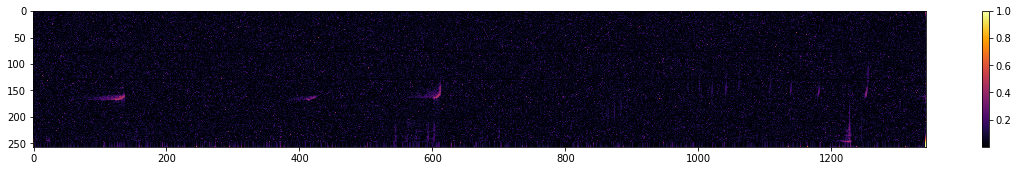

In [13]:
def plot_sequence(X, k):
    plt.figure(figsize = (20, 2.5))
    x = X[k].cpu().detach().numpy()
    plt.imshow(np.rot90(x), interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    print(x.shape)

k = np.random.randint(0, batch_size)
X1, Y1 = next(iter(train_loader))
X1, Y1 = X1.cuda(), Y1.cuda()
X1 = preprocess(X1)
X1 = custom_augment_fn(X1.unsqueeze(1))
plot_sequence(X1.squeeze(1), k)

In [14]:
criterion = None
optimizer = torch.optim.Adam(model.parameters(), lr=lr, )
    
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=5)
scheduler = None

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [15]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, _ = mixup(inputs, labels, num_classes, min_seq=1, max_seq=3, p_min=0.3)
        inputs = preprocess(inputs).unsqueeze(1)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        loss = model(inputs)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        optimizer.step()
        model.update_moving_average()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
    
        # Perform learning rate step
        #scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    
    return epoch_loss

In [16]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0

        for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs = inputs.to(device)
            inputs = preprocess(inputs).unsqueeze(1)
                    
            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            loss = model(inputs)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / num_samples
    
    return epoch_loss

# Training

In [17]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size
}

wandb.init(project="BigBAT-pretrain", entity="frankfundel", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)
2023-01-01 14:25:17.663198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 14:25:18.097324: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-01 14:25:20.720983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory

In [18]:
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f}'.format(train_loss), flush=True)
    
    val_loss = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f}'.format(val_loss), flush=True)
    
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
    })
        
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(BATencode.state_dict(), 'BigBAT-BYOL.pth')

# Load after training
BATencode.load_state_dict(torch.load('BigBAT-BYOL.pth'))

==================== Starting at epoch 0 ====================


100%|█████████████████████████████████████████| 177/177 [03:59<00:00,  1.35s/it]

Training loss: 3.7764



100%|███████████████████████████████████████████| 46/46 [00:35<00:00,  1.28it/s]

Validation loss: 3.8788
val_loss decreased, saving model
==================== Starting at epoch 1 ====================



100%|█████████████████████████████████████████| 177/177 [03:54<00:00,  1.32s/it]

Training loss: 3.4544



100%|███████████████████████████████████████████| 46/46 [00:26<00:00,  1.73it/s]

Validation loss: 3.4534
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



100%|█████████████████████████████████████████| 177/177 [03:51<00:00,  1.31s/it]

Training loss: 3.0959



100%|███████████████████████████████████████████| 46/46 [00:31<00:00,  1.45it/s]

Validation loss: 3.1661
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



100%|█████████████████████████████████████████| 177/177 [03:46<00:00,  1.28s/it]

Training loss: 2.7397



100%|███████████████████████████████████████████| 46/46 [00:32<00:00,  1.43it/s]

Validation loss: 3.2897
==================== Starting at epoch 4 ====================



100%|█████████████████████████████████████████| 177/177 [03:47<00:00,  1.28s/it]

Training loss: 2.3302



100%|███████████████████████████████████████████| 46/46 [00:32<00:00,  1.40it/s]

Validation loss: 3.3920
==================== Starting at epoch 5 ====================



100%|█████████████████████████████████████████| 177/177 [03:50<00:00,  1.30s/it]

Training loss: 1.9378



100%|███████████████████████████████████████████| 46/46 [00:32<00:00,  1.42it/s]

Validation loss: 2.9811
val_loss decreased, saving model
==================== Starting at epoch 6 ====================



100%|█████████████████████████████████████████| 177/177 [03:56<00:00,  1.34s/it]

Training loss: 1.6173



100%|███████████████████████████████████████████| 46/46 [00:32<00:00,  1.40it/s]

Validation loss: 2.5996
val_loss decreased, saving model
==================== Starting at epoch 7 ====================



100%|█████████████████████████████████████████| 177/177 [03:48<00:00,  1.29s/it]

Training loss: 1.3426



100%|███████████████████████████████████████████| 46/46 [00:30<00:00,  1.50it/s]

Validation loss: 2.9983
==================== Starting at epoch 8 ====================



100%|█████████████████████████████████████████| 177/177 [03:51<00:00,  1.31s/it]

Training loss: 1.1468



100%|███████████████████████████████████████████| 46/46 [00:35<00:00,  1.28it/s]

Validation loss: 3.4195
==================== Starting at epoch 9 ====================



100%|█████████████████████████████████████████| 177/177 [03:55<00:00,  1.33s/it]

Training loss: 0.9303



100%|███████████████████████████████████████████| 46/46 [00:30<00:00,  1.49it/s]

Validation loss: 2.9841
==================== Starting at epoch 10 ====================



100%|█████████████████████████████████████████| 177/177 [03:53<00:00,  1.32s/it]

Training loss: 0.7962



100%|███████████████████████████████████████████| 46/46 [00:29<00:00,  1.53it/s]

Validation loss: 2.5564
val_loss decreased, saving model


==================== Starting at epoch 11 ====================


100%|█████████████████████████████████████████| 177/177 [03:47<00:00,  1.29s/it]

Training loss: 0.6729



100%|███████████████████████████████████████████| 46/46 [00:32<00:00,  1.42it/s]

Validation loss: 2.1674
val_loss decreased, saving model
==================== Starting at epoch 12 ====================



100%|█████████████████████████████████████████| 177/177 [03:55<00:00,  1.33s/it]

Training loss: 0.5770



100%|███████████████████████████████████████████| 46/46 [00:32<00:00,  1.41it/s]

Validation loss: 2.3419
==================== Starting at epoch 13 ====================



100%|█████████████████████████████████████████| 177/177 [03:47<00:00,  1.28s/it]

Training loss: 0.4890



100%|███████████████████████████████████████████| 46/46 [00:31<00:00,  1.47it/s]

Validation loss: 2.4909
==================== Starting at epoch 14 ====================



100%|█████████████████████████████████████████| 177/177 [03:51<00:00,  1.31s/it]

Training loss: 0.4208



100%|███████████████████████████████████████████| 46/46 [00:35<00:00,  1.29it/s]

Validation loss: 2.3932
==================== Starting at epoch 15 ====================



100%|█████████████████████████████████████████| 177/177 [03:46<00:00,  1.28s/it]

Training loss: 0.3845



100%|███████████████████████████████████████████| 46/46 [00:34<00:00,  1.34it/s]

Validation loss: 2.7221
==================== Starting at epoch 16 ====================



100%|█████████████████████████████████████████| 177/177 [03:58<00:00,  1.35s/it]

Training loss: 0.3421



100%|███████████████████████████████████████████| 46/46 [00:36<00:00,  1.25it/s]

Validation loss: 1.8851
val_loss decreased, saving model
==================== Starting at epoch 17 ====================



100%|█████████████████████████████████████████| 177/177 [03:50<00:00,  1.30s/it]

Training loss: 0.3081



100%|███████████████████████████████████████████| 46/46 [00:35<00:00,  1.29it/s]

Validation loss: 2.1853
==================== Starting at epoch 18 ====================



100%|█████████████████████████████████████████| 177/177 [04:02<00:00,  1.37s/it]

Training loss: 0.2932



100%|███████████████████████████████████████████| 46/46 [00:29<00:00,  1.56it/s]

Validation loss: 2.0819
==================== Starting at epoch 19 ====================



100%|█████████████████████████████████████████| 177/177 [03:50<00:00,  1.30s/it]

Training loss: 0.2715



100%|███████████████████████████████████████████| 46/46 [00:31<00:00,  1.47it/s]

Validation loss: 2.1116
==================== Starting at epoch 20 ====================



100%|█████████████████████████████████████████| 177/177 [03:50<00:00,  1.30s/it]

Training loss: 0.2649



100%|███████████████████████████████████████████| 46/46 [00:31<00:00,  1.47it/s]

Validation loss: 2.6065
==================== Starting at epoch 21 ====================



100%|█████████████████████████████████████████| 177/177 [03:50<00:00,  1.30s/it]

Training loss: 0.2627



100%|███████████████████████████████████████████| 46/46 [00:31<00:00,  1.46it/s]

Validation loss: 2.1639
==================== Starting at epoch 22 ====================



100%|█████████████████████████████████████████| 177/177 [03:53<00:00,  1.32s/it]

Training loss: 0.2388



100%|███████████████████████████████████████████| 46/46 [00:30<00:00,  1.51it/s]

Validation loss: 2.1624
==================== Starting at epoch 23 ====================



100%|█████████████████████████████████████████| 177/177 [04:00<00:00,  1.36s/it]

Training loss: 0.2489



100%|███████████████████████████████████████████| 46/46 [00:31<00:00,  1.47it/s]

Validation loss: 2.0962
==================== Starting at epoch 24 ====================



100%|█████████████████████████████████████████| 177/177 [03:56<00:00,  1.34s/it]

Training loss: 0.2267



100%|███████████████████████████████████████████| 46/46 [00:29<00:00,  1.55it/s]

Validation loss: 2.3078
==================== Starting at epoch 25 ====================



100%|█████████████████████████████████████████| 177/177 [03:55<00:00,  1.33s/it]

Training loss: 0.2182



100%|███████████████████████████████████████████| 46/46 [00:32<00:00,  1.43it/s]

Validation loss: 2.8833
==================== Starting at epoch 26 ====================



100%|█████████████████████████████████████████| 177/177 [03:45<00:00,  1.27s/it]

Training loss: 0.2241



 48%|████████████████████▌                      | 22/46 [00:13<00:14,  1.61it/s]


KeyboardInterrupt: 

# Evaluation